In [1]:
from neuron import h
import numpy as np
import time
import brainstate
import braintools
import brainunit as u
import matplotlib.pyplot as plt
import jax.numpy as jnp
import braincell
from scipy.interpolate import interp1d
import os

h.load_file('stdrun.hoc')
s = u.siemens / u.cm ** 2
os.environ["CUDA_VISIBLE_DEVICES"] = "6"

--No graphics will be displayed.


## Create multicompartment cell in Neuron

In [2]:
class Neuron:
    def __init__(self, num, connection_mode):
        self.num = num
        self.sec = []
        self.create_sections()
        self.set_params()
        if connection_mode == 'line':
            self.connect_line()
        elif connection_mode == 'star':
            self.connect_star()
        
        
    def create_sections(self):
        for i in range(self.num):
            sec = h.Section(name=f'sec_{i}')
            self.sec.append(sec)
    
    def connect_line(self):
        for i in range(1, self.num):
            self.sec[i].connect(self.sec[i - 1](1))

    def connect_star(self):
        for i in range(1, self.num):
            self.sec[i].connect(self.sec[0](1))

    def set_params(self):
        Ra = 100 * np.ones(self.num)
        cm = 1 * np.ones(self.num)
        diam = 10 * np.ones(self.num)
        L = 100 * np.ones(self.num)
        L[0] = 10

        for i, sec in enumerate(self.sec):
            sec.Ra = Ra[i]
            sec.cm = cm[i]
            sec.diam = diam[i]
            sec.L = L[i]
            sec.insert('pas')
            sec(0.5).pas.g = 0.001
            sec(0.5).pas.e = -65

## run
def NeuronRun(cell, stim, tstop, dt, v_init):
    ## create record vector
    t_vec = h.Vector()
    t_vec.record(h._ref_t)
    v_vecs = []

    for sec in cell.sec:
        v_vec = h.Vector()
        v_vec.record(sec(0.5)._ref_v)
        v_vecs.append(v_vec)

    ## simulation
    h.dt = dt
    h.v_init = v_init
    h.finitialize()
    h.continuerun(tstop)
    return t_vec, v_vecs

## different stim func
def step_stim(cell, delay, dur, amp):
    stim = h.IClamp(cell.sec[0](0.5))
    stim.delay = delay
    stim.dur = dur
    stim.amp = amp
    return stim

def sine_stim(cell, amp, freq, phase, tstop, dt):
    t = np.arange(0, tstop, dt)  
    I = amp * np.sin(2 * np.pi * freq * t + phase) 

    t_vec = h.Vector(t)
    I_vec = h.Vector(I)
    ic = h.IClamp(cell.sec[0](0.5))
    ic.delay = 0  
    ic.dur = tstop 
    I_vec.play(ic._ref_amp, t_vec)
    
    return ic, t_vec, I_vec

def random_sine_combination(t, num_sines, seed=None):
    if seed is not None:
        np.random.seed(seed)
    result = np.zeros_like(t)
    for _ in range(num_sines):
        amplitude = np.random.uniform(-1, 1)
        frequency = np.random.uniform(0.1, 1)
        phase = np.random.uniform(0, 2 * np.pi)
        result += amplitude * np.sin(2 * np.pi * frequency * t + phase)
    return result

def random_sine_stim(cell, seed, num_sines, tstop, dt):
    t = np.arange(0, tstop, dt)  
    I = random_sine_combination(t, num_sines, seed)

    t_vec = h.Vector(t)
    I_vec = h.Vector(I)
    ic = h.IClamp(cell.sec[0](0.5))
    ic.delay = 0  
    ic.dur = tstop 
    I_vec.play(ic._ref_amp, t_vec)

    return ic, t_vec, I_vec

def random_stim(cell, seed, upper, lower, tstop, dt):
    np.random.seed(seed)
    t = np.arange(0, tstop, dt)  
    I = np.random.uniform(lower, upper, size=len(t))

    t_vec = h.Vector(t)
    I_vec = h.Vector(I)
    ic = h.IClamp(cell.sec[0](0.5))
    ic.delay = 0  
    ic.dur = tstop 
    I_vec.play(ic._ref_amp, t_vec)

    return ic, t_vec, I_vec

## Create multicompartment cell in Braincell

In [3]:
class Braincell(braincell.neuron.MultiCompartment):
    def __init__(self,  size, connection, Ra, cm, diam, L, solver = 'exp_euler'):
        super().__init__(
            size=size,
            connection= connection,
            Ra= Ra * u.ohm * u.cm,
            cm= cm * u.uF / u.cm ** 2,
            diam=diam * u.um,
            L= L * u.um,
            V_th=20. * u.mV,
            V_initializer=brainstate.init.Constant(-65 * u.mV),
            spk_fun=brainstate.surrogate.ReluGrad(),
            solver = solver
        )
        self.IL = braincell.channel.IL(self.varshape, E= -65 * u.mV, g_max= 0.001 * s)
        '''
        self.na =  braincell.ion.SodiumFixed(self.varshape, E= 50. * u.mV)
        self.na.add(INa = INa(self.varshape, g_max= gna * u.mS / (u.cm ** 2)))

        self.k = braincell.ion.PotassiumFixed(self.varshape, E= -80. * u.mV)
        self.k.add(IK =IK(self.varshape, g_max= gk * u.mS / (u.cm ** 2)))
        '''
    def step_run(self, t, inp):
        with brainstate.environ.context(t=t):
            self.update(inp)
            return self.V.value
        
def con_line(num_compartment):
    connection = [[i, i + 1] for i in range(num_compartment - 1)]
    return connection

def con_star(num_compartment):
    connection = [[0, i + 1] for i in range(num_compartment - 1)]
    return connection

def Braincell_create(num, connection_mode, solver): 
    size = (1, num)
    Ra = 100 * np.ones(num)
    cm = 1 * np.ones(num)
    diam = 10 * np.ones(num)
    L = 100 * np.ones(num)
    L[0] = 10
    ## connection set
    if connection_mode == 'line':
        connection = con_line(num)
    elif connection_mode == 'star':
        connection = con_star(num)

    return Braincell(size, connection, Ra, cm, diam, L, solver=solver)  

## run 
def BraincellRun(neu,I, dt):
    ## time
    brainstate.environ.set(dt= dt * u.ms)
    times = u.math.arange(I.shape[0]) * brainstate.environ.get_dt()
    ## init and reset
    neu.init_state()
    neu.reset_state()
    ## run
    vs = brainstate.compile.for_loop(neu.step_run, times, I)
    return times.to_decimal(u.ms), vs.to_decimal(u.mV)

## different input func
def step_input(num, dur, amp, dt):
    brainstate.environ.set(dt= dt * u.ms)
    value = jnp.zeros((len(dur),num))
    for i in range(len(value)):
        value = value.at[i, 0].set(amp[i])
    I = braintools.input.section_input(values=value, durations= dur * u.ms) * u.nA
    return I

def sine_input(num, amp, freq, phase, tstop, dt):
    time = np.arange(0, tstop, dt)
    I = np.zeros((len(time),num)) * u.nA
    I[:,0] = amp * np.sin(2 * np.pi * freq * time + phase) * u.nA
    return I

def random_sin_input(num, seed, num_sines, tstop, dt):
    time = np.arange(0, tstop, dt)
    I = np.zeros((len(time),num)) * u.nA
    I[:,0] =  random_sine_combination(time, num_sines, seed)*u.nA
    return I

def random_input(num, seed, upper, lower, tstop, dt):
    np.random.seed(seed)
    time = np.arange(0, tstop, dt)
    I = np.zeros((len(time),num)) * u.nA
    I[:,0] = np.random.uniform(lower, upper, size=len(time)) * u.nA
    return I


## Simulation in Neuron and Braincell

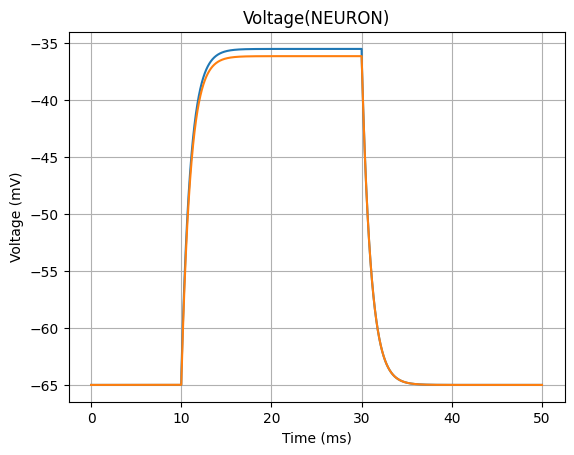

In [4]:
num = 2
neuron = Neuron(num, connection_mode = 'line')
stim = step_stim(neuron, delay=10, dur=20, amp=1)
#stim = sine_stim(cell=neuron, amp=1, freq=1, phase=0, tstop=10, dt=0.001)
#stim = random_stim(cell=neuron, seed=1, upper=1, lower=0, tstop=10, dt=0.1)
#stim = random_sine_stim(cell=neuron, seed=2, num_sines=100, tstop=11, dt=0.001)
t_vec, v_vecs = NeuronRun(neuron, stim=stim, tstop=50, dt=0.001, v_init=-65)

for i in range(num):
    plt.plot(t_vec, v_vecs[i], label=f'sec_{i}')
#plt.legend()
plt.xlabel('Time (ms)')
plt.ylabel('Voltage (mV)')
plt.title('Voltage(NEURON)')
plt.grid(True)
plt.show()

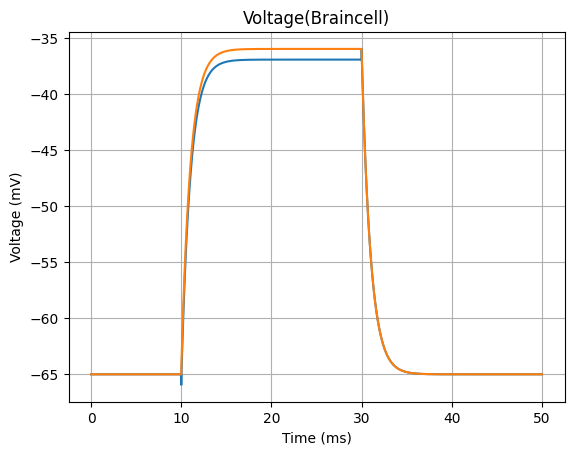

In [5]:
cell = Braincell_create(num=num, connection_mode='line', solver='splitting')
I = step_input(num=num, dur=[10,20,20], amp=[0,1,0], dt=0.01)
#I = sine_input(num=num, amp=1, freq= 0.3, phase=0, tstop= 10, dt=0.1)
#I = random_input(num=num, seed=1, upper=1, lower=0, tstop=10, dt=0.01)
#I = random_sin_input(num=num, seed=1, num_sines=10, tstop=10, dt=0.01)
t1, v1 = BraincellRun(neu=cell, I=I, dt=0.01)

for i in range(num):
    plt.plot(t1,v1[:,:,i])
#plt.legend()
plt.xlabel('Time (ms)')
plt.ylabel('Voltage (mV)')
plt.title('Voltage(Braincell)')
plt.grid(True)
plt.show()

## Compare the error

### 1. check error of spliiting ～ O(dt)

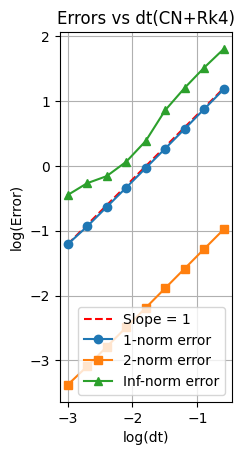

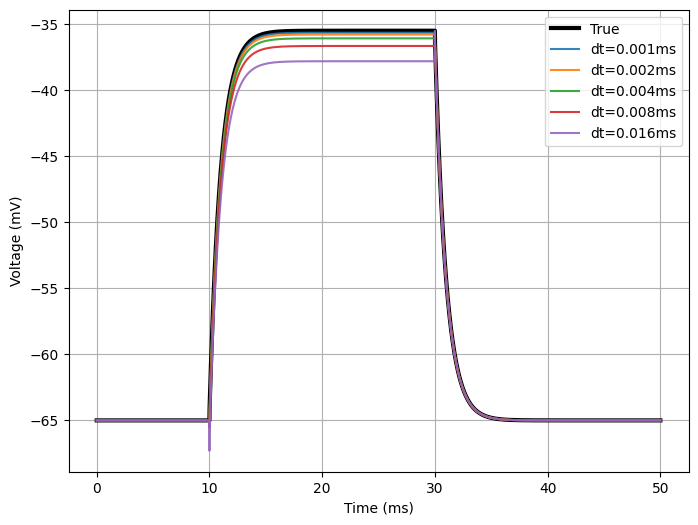

In [6]:
num_dt =9
dt_list = [0.001 * 2 ** i for i in range(num_dt)]
error_1_list = []
error_2_list = []
error_inf_list = []
v_list = [] 
num = 2

## standerd curve 
neuron = Neuron(num, connection_mode = 'line')
stim = step_stim(neuron, delay=10, dur=20, amp=1)
#stim = sine_stim(cell=neuron, amp=1, freq=0.3, phase=0, tstop=11, dt=0.001)
#stim = random_stim(cell=neuron, seed=1, upper=1, lower=0, tstop=10, dt=0.1)
#stim = random_sine_stim(cell=neuron, seed=1, num_sines=10, tstop=11, dt=0.001)

t_vec, v_vecs = NeuronRun(neuron, stim=stim, tstop=51, dt=0.001, v_init=-65)
t_vec = np.array(t_vec);t_vec = t_vec[:-1000]
v_vecs = np.array(v_vecs);v_vecs = v_vecs[:,:-1000]

v_list.append(v_vecs[0])

for i in range(num_dt):
    cell = Braincell_create(num=num, connection_mode='line', solver='splitting')
    I = step_input(num=num, dur=[10,20,21], amp=[0,1,0], dt=dt_list[i])
    #I = sine_input(num=num, amp=1, freq= 0.3, phase=0, tstop= 11, dt=dt_list[i])
    #I = random_input(num=num, seed=1, upper=1, lower=0, tstop=10, dt=dt_list[i])
    #I = random_sin_input(num=num, seed=1, num_sines=10, tstop=11, dt=dt_list[i])
    t1, v1 = BraincellRun(neu=cell, I=I, dt=dt_list[i])

    ## interpolation for the same length
    f = interp1d(t1, v1[:,:,0].reshape(-1), kind='linear')
    v_list.append(f(t_vec))
    ## error
    error_1_list.append(np.linalg.norm(v_vecs[0]-f(t_vec),1)/len(v_vecs[0]))
    error_2_list.append(np.linalg.norm(v_vecs[0]-f(t_vec),2)/len(v_vecs[0]))
    error_inf_list.append(np.linalg.norm(v_vecs[0]-f(t_vec),np.inf))

# log_e
log_dt = np.log10(dt_list)
log_error_1 = np.log10(error_1_list)
log_error_2 = np.log10(error_2_list)
log_error_inf = np.log10(error_inf_list)

# ref line
x0 = log_dt[0]
y0 = log_error_1[0]
b = y0 - 1 * x0  
reference_line_y = 1 * log_dt + b
plt.plot(log_dt, reference_line_y, linestyle='--', color='red', label='Slope = 1')

# plot
plt.plot(log_dt, log_error_1, marker='o', label='1-norm error')
plt.plot(log_dt, log_error_2, marker='s', label='2-norm error')
plt.plot(log_dt, log_error_inf, marker='^', label='Inf-norm error')

plt.title('Errors vs dt(CN+Rk4)')
plt.xlabel('log(dt)')
plt.ylabel('log(Error)')
plt.grid(True)
plt.legend()

plt.gca().set_aspect('equal', adjustable='box')
plt.show()

## dt compare
plt.figure(figsize=(8, 6))
for i in range(num_dt+1):
    if i == 0:
        plt.plot(t_vec,v_list[i], linewidth=3,color = 'black', label = 'True')
    elif i<=5:
        plt.plot(t_vec,v_list[i], alpha = 0.9, label = f'dt={dt_list[i-1]}ms')
    plt.legend()
plt.xlabel('Time (ms)')
plt.ylabel('Voltage (mV)')
#plt.title('Voltage')
plt.grid(True)
plt.show()
